In [1]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
df = pd.read_csv('car_price_prediction.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,19237.0,4.557654e+07,936591.422799,20746880.0,45698374.0,45772308.0,45802036.0,45816654.0
Price,19237.0,1.855593e+04,190581.269684,1.0,5331.0,13172.0,22075.0,26307500.0
Prod. year,19237.0,2.010913e+03,5.668673,1939.0,2009.0,2012.0,2015.0,2020.0
Cylinders,19237.0,4.582991e+00,1.199933,1.0,4.0,4.0,4.0,16.0
Airbags,19237.0,6.582627e+00,4.320168,0.0,4.0,6.0,12.0,16.0


1. Первичный анализ.

In [5]:
translations = {
    'Price' : 'Цена',
    'Prod. year' : 'Дата производства',
}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

def price_by_category(df_, group_by, figsize=(24,6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    df_.groupby(group_by)["Price"].mean().sort_values().plot(kind="bar", ax=axes[0], title='Средние')
    df_.groupby(group_by)["Price"].median().sort_values().plot(kind="bar", ax=axes[1], title='Медианы')
    return df_.groupby(group_by)["Price"].agg(['mean', 'median', "count"])

- Price, целевой признак

In [6]:
df["Price"].sort_values(ascending=True).tail(20)

2912       172486
2768       172486
9248       172486
6468       172486
4722       175622
13328      193184
1145       194438
7353       216391
2283       219527
7283       228935
15283      250574
5840       254024
10759      260296
7749       288521
9367       297930
14839      297930
5008       308906
1225       627220
8541       872946
16983    26307500
Name: Price, dtype: int64

Смотрим количество машин в группах по 100к

In [7]:
(
    len(df[df.Price <= 100000]),
    len(df[(df.Price > 100000) & (df.Price <= 200000)]),
    len(df[df.Price > 200000]),
)

(19124, 100, 13)

In [8]:
#Для начала отбросим все свыше 100к
df = df[(df.Price < 100000)]

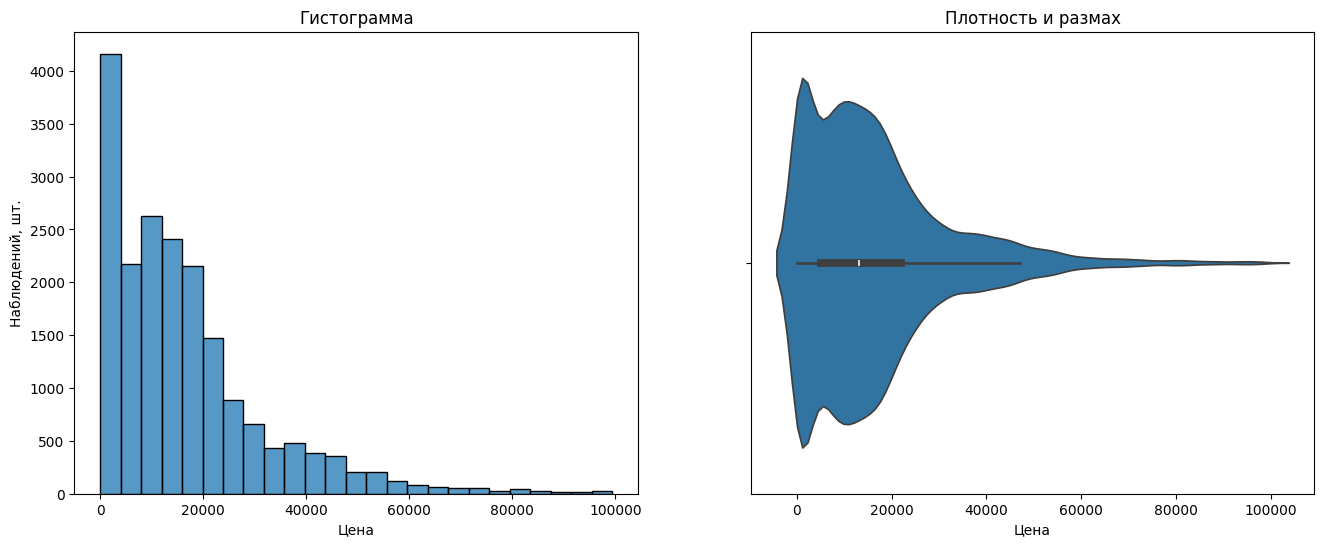

In [9]:
eda_visualize(df["Price"]);

In [10]:
(
    len(df[df.Price <= 1000]),
    len(df[(df.Price > 1000) & (df.Price <= 2000)]),
    len(df[(df.Price > 2000) & (df.Price <= 3000)]),
    len(df[(df.Price > 3000) & (df.Price <= 4000)]),
    len(df[(df.Price > 4000) & (df.Price <= 5000)]),
    len(df[(df.Price > 5000) & (df.Price <= 6000)]),
    len(df[(df.Price > 6000) & (df.Price <= 7000)]),
    len(df[(df.Price > 7000) & (df.Price <= 8000)]),
    len(df[(df.Price > 8000) & (df.Price <= 9000)]),
    len(df[(df.Price > 10000) & (df.Price <= 11000)]),
)

(2585, 627, 436, 526, 452, 544, 540, 692, 569, 791)

Значения меньше 1000 являются выбросом с количественной точки зрения.
Может создать отдельную модель для значений меньше 1000?
Посмотрим эту тысячу по сотням.

In [11]:
(
    len(df[df.Price <= 100]),
    len(df[(df.Price > 100) & (df.Price <= 200)]),
    len(df[(df.Price > 200) & (df.Price <= 300)]),
    len(df[(df.Price > 300) & (df.Price <= 400)]),
    len(df[(df.Price > 400) & (df.Price <= 500)]),
    len(df[(df.Price > 500) & (df.Price <= 600)]),
    len(df[(df.Price > 600) & (df.Price <= 700)]),
    len(df[(df.Price > 700) & (df.Price <= 800)]),
    len(df[(df.Price > 800) & (df.Price <= 900)]),
    len(df[(df.Price > 1000) & (df.Price <= 1100)]),
)

(381, 279, 240, 487, 278, 185, 196, 278, 122, 125)

In [12]:
#Аналогично отбросим все ниже 1000
df = df[(df.Price >= 1000)]

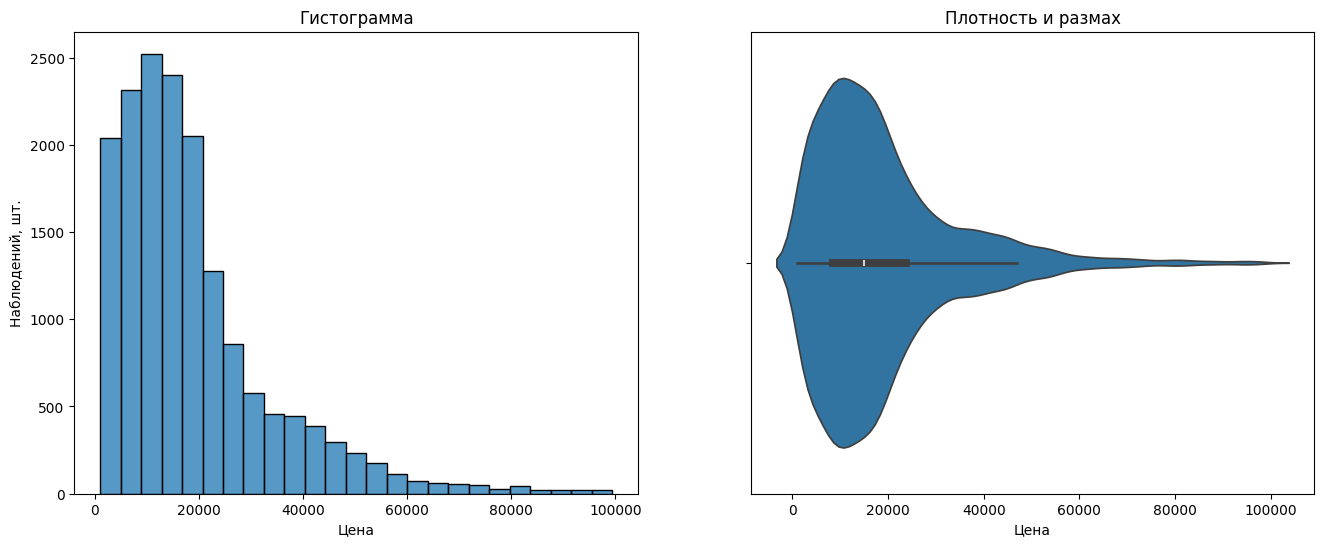

In [13]:
eda_visualize(df["Price"])

- Levy: численный, дискретный, слабая корреляция c Price 0.14, группировка ничего не дала.

Levy перевод - сбор. Похоже на какой-то налог.

По информации с kaggle: "Tax of importing and exporting the cars."
Учитывая что всего 9 уникальных значений, то это дискретная величина.
Так же указано, что не определена валюта и смысл для "-".

Принял "-", как 0 и изменил тип колонки на числовой.

In [14]:
df["Levy"] = df["Levy"].replace("-", 0)
df = df.astype({"Levy": "int32"})

In [15]:
df["Levy"].value_counts().sort_values(ascending=False)

Levy
0       5383
765      460
891      439
639      382
640      356
        ... 
1836       1
328        1
4860       1
3811       1
1045       1
Name: count, Length: 537, dtype: int64

In [16]:
df["HasLevy"] = df["Levy"] > 0

,mean,median,count
HasLevy,,,
False,16730.481887,12858.0,5383
True,19958.866213,16151.0,11167


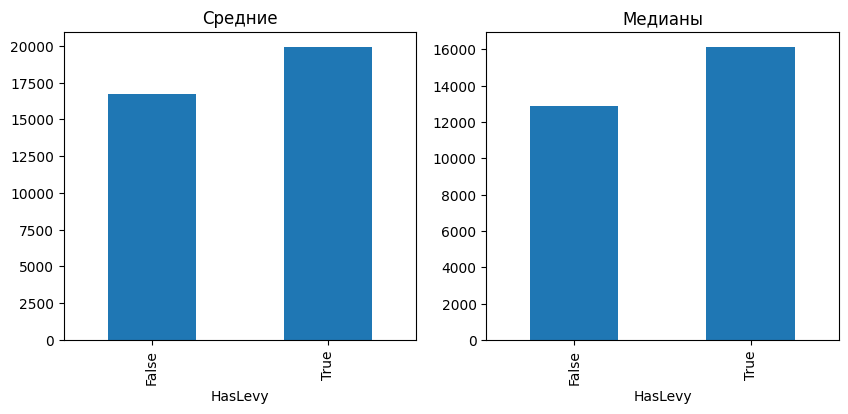

In [17]:
price_by_category(df, "HasLevy", figsize=(10,4))

- Manufacturer:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

In [18]:
df.loc[df["Manufacturer"] == "სხვა", "Manufacturer"] = df["Model"].apply(lambda x: x.split(" ")[0])

,mean,median,count
Manufacturer,,,
ACURA,8710.500000,4626.0,10
ALFA ROMEO,9890.250000,8522.0,4
ASTON MARTIN,54000.000000,54000.0,1
AUDI,17292.664948,11760.0,194
BMW,21422.383369,15681.0,926
...,...,...,...
UAZ,5290.750000,5331.0,12
VAZ,4694.723404,3607.0,47
VOLKSWAGEN,12576.636704,12544.0,534


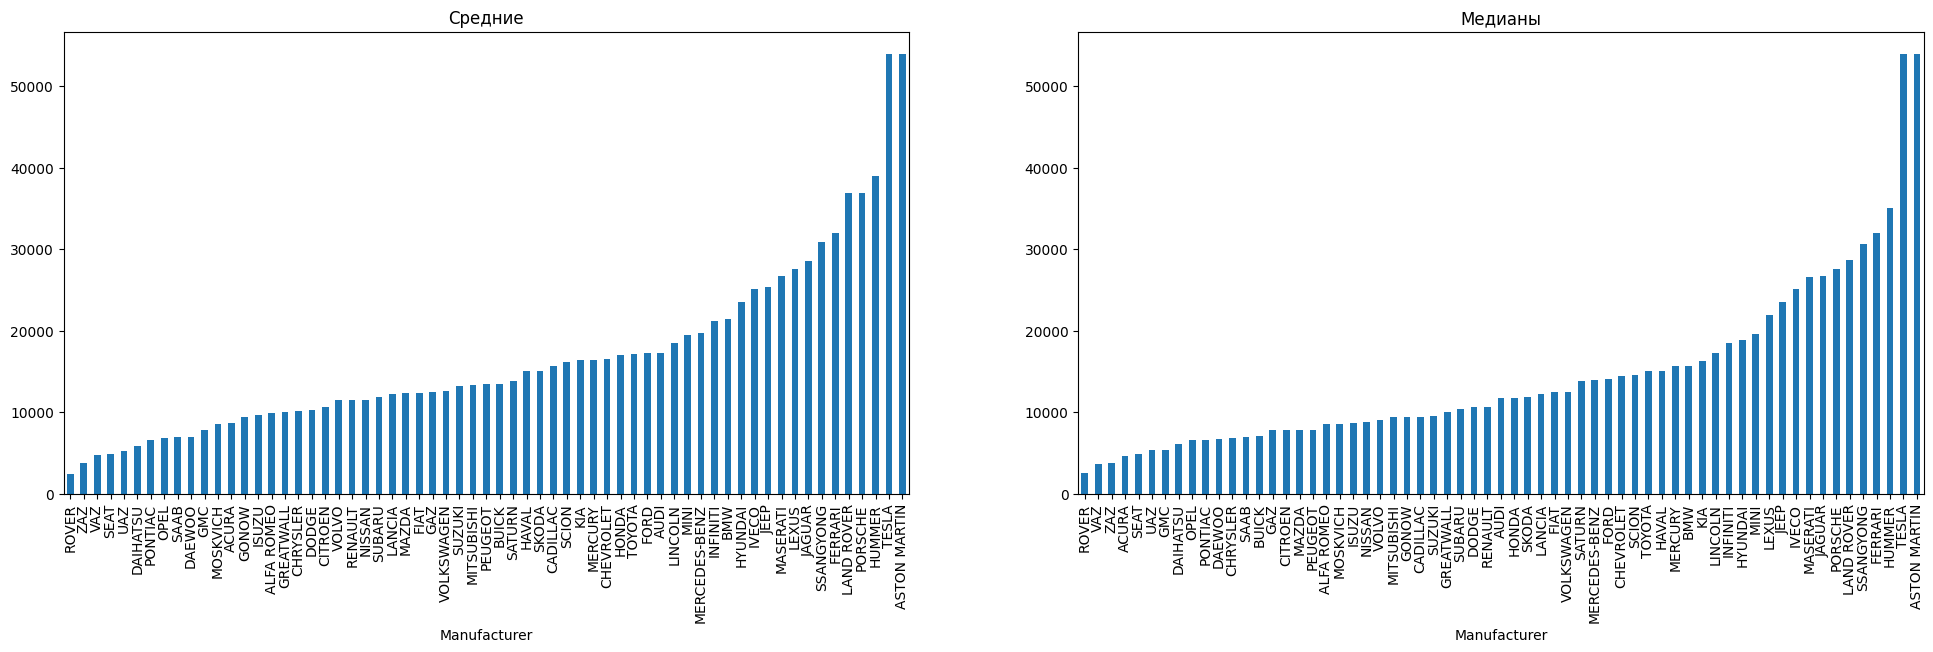

In [19]:
price_by_category(df, "Manufacturer", figsize=(24,6))

- Model (не знаю как оценить наличие зависимости, очень много категорий относительно размера выборки 1.5к/16.5к, хороший кандидат для удаления)

- Prod. year: численный, дискретный, средняя корреляция с Price 0.41

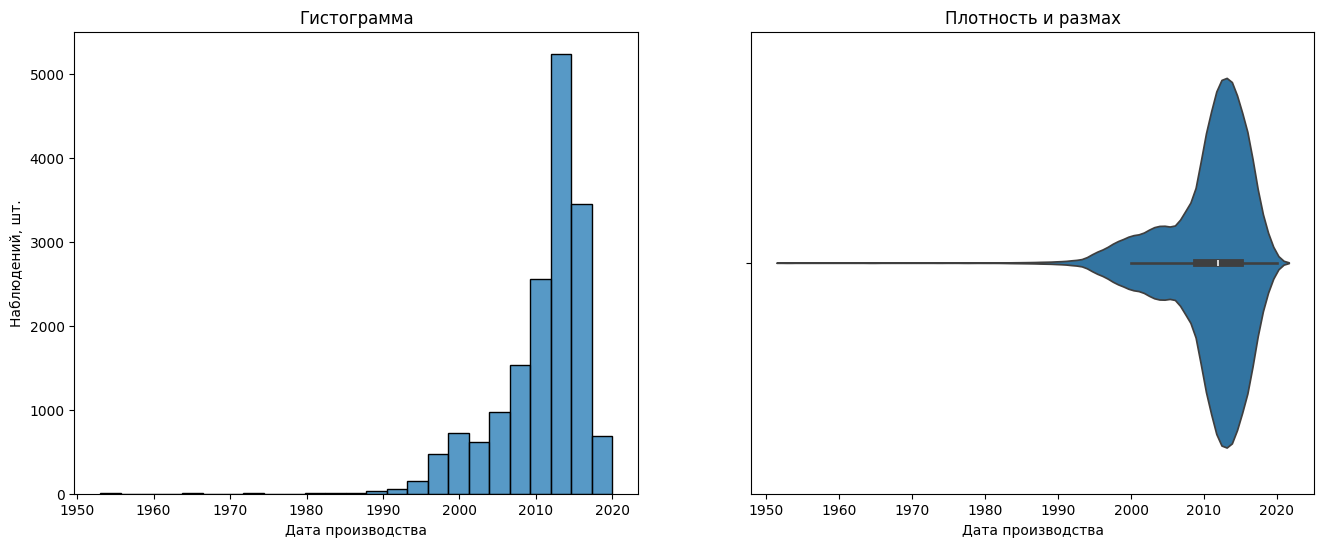

In [20]:
eda_visualize(df["Prod. year"])

In [21]:
df = df[df["Prod. year"] >= 1990]

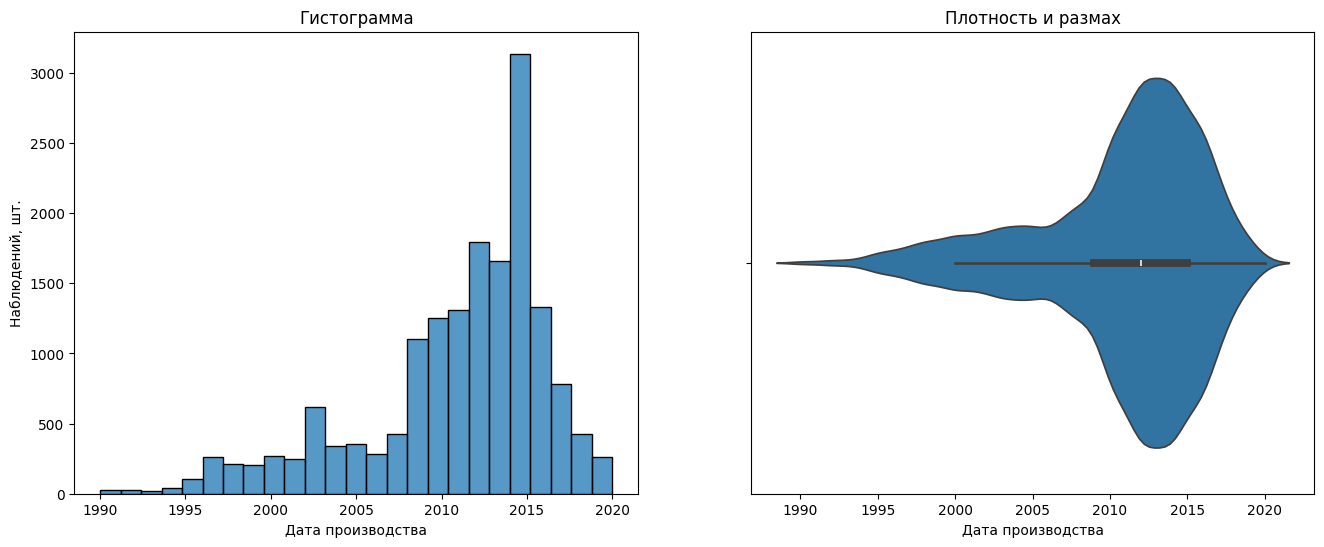

In [22]:
eda_visualize(df["Prod. year"])

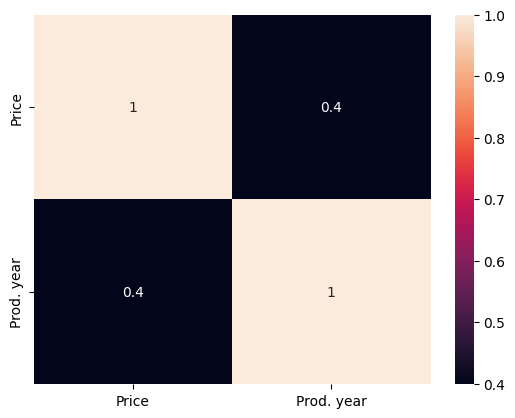

In [23]:
sns.heatmap(df[["Price", "Prod. year"]].corr(), annot=True);

- Category:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Category,,,
Cabriolet,26022.235294,19444.0,34
Coupe,19252.369835,15290.5,484
Goods wagon,9830.464602,8781.0,226
Hatchback,13368.208126,11917.0,2412
Jeep,26342.991606,22693.0,4527
Limousine,23677.500000,27441.0,4
Microbus,19509.110345,16308.0,290
Minivan,21175.070740,18325.5,622
Pickup,28850.181818,23050.5,44


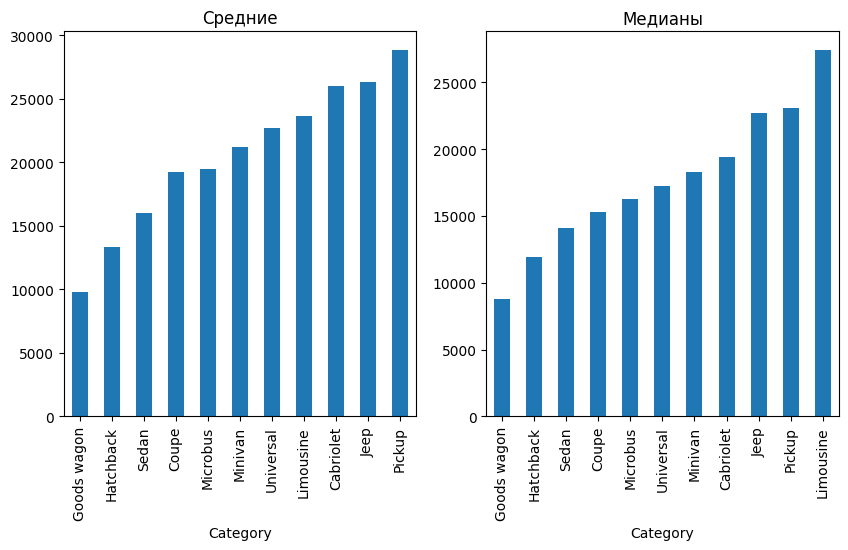

In [24]:
price_by_category(df, "Category", figsize=(10, 5))

- Leather interior: логический, среднее при наличии возрастает, что говорит о связи

In [25]:
df["Leather interior"] = pd.get_dummies(df["Leather interior"], drop_first=True)

,mean,median,count
Leather interior,,,
False,14005.715582,12231.0,4961
True,21072.237814,16935.0,11530


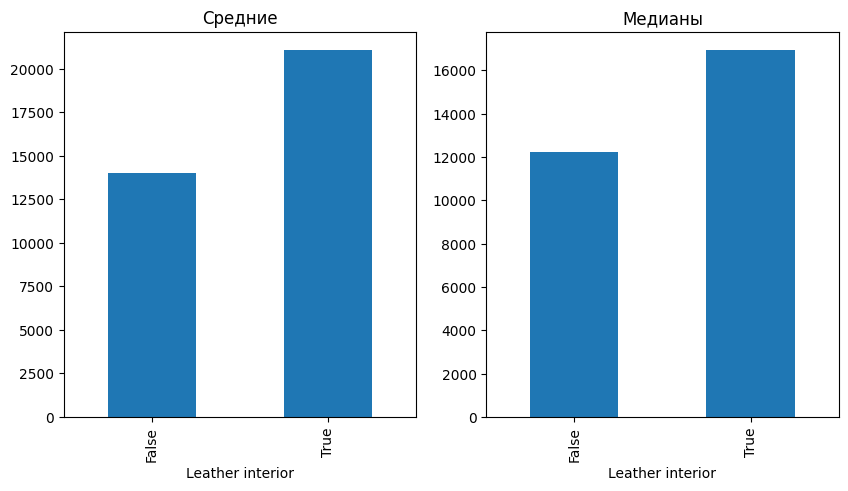

In [26]:
price_by_category(df, "Leather interior", figsize=(10, 5))

- Fuel type:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Fuel type,,,
CNG,8686.527083,7527.0,480
Diesel,25096.119451,21953.0,3717
Hybrid,14389.396284,13291.0,2637
Hydrogen,20385.000000,20385.0,1
LPG,13582.223112,11604.0,874
Petrol,18757.948827,15053.0,8696
Plug-in Hybrid,23700.453488,22737.0,86


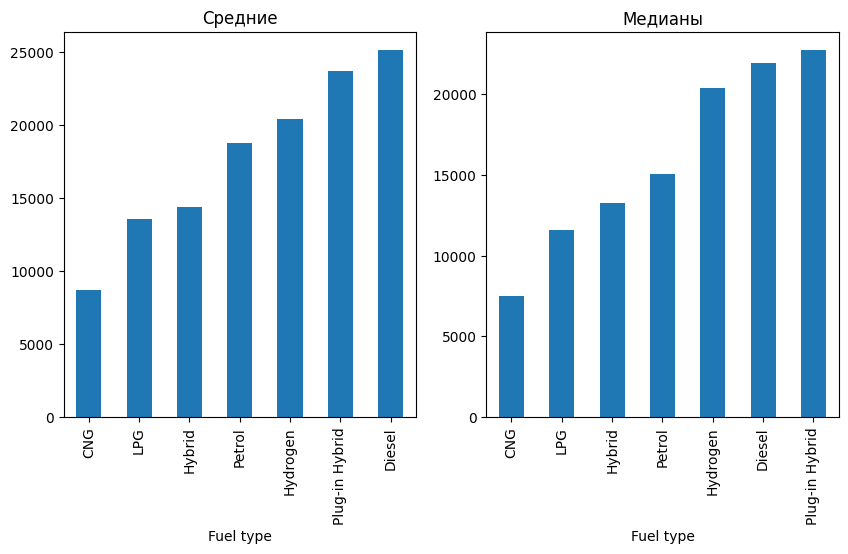

In [27]:
price_by_category(df, "Fuel type", figsize=(10, 5))

- Engine volume: численный, дискретный, стоит попробовать сгруппировать

In [28]:
def has_turbo(x: str) -> bool:
    return "Turbo" in x
df["Turbo"] = df["Engine volume"].apply(has_turbo)

In [29]:
def engine_volume_to_float(x: str) -> float:
    return float(x.replace(" Turbo", ""))
df["Engine volume"] = df["Engine volume"].apply(engine_volume_to_float)

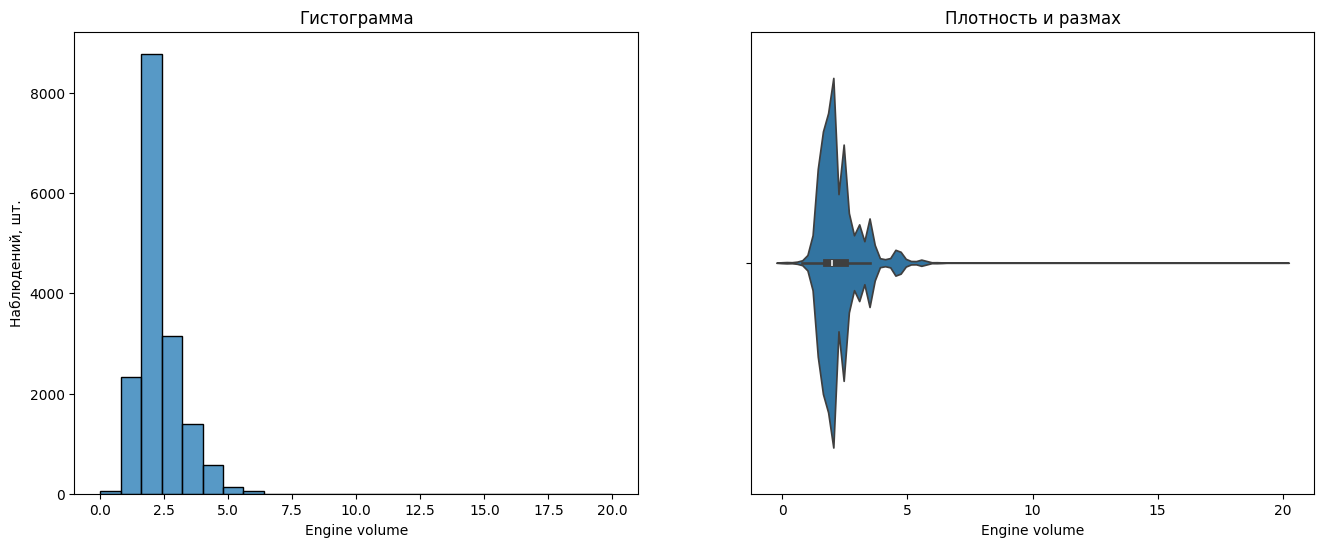

In [30]:
eda_visualize(df["Engine volume"])

- Turbo: логический, среднее при наличии возрастает, что говорит о связи

,mean,median,count
Turbo,,,
False,18200.599864,14426.0,14660
True,24917.784271,19444.0,1831


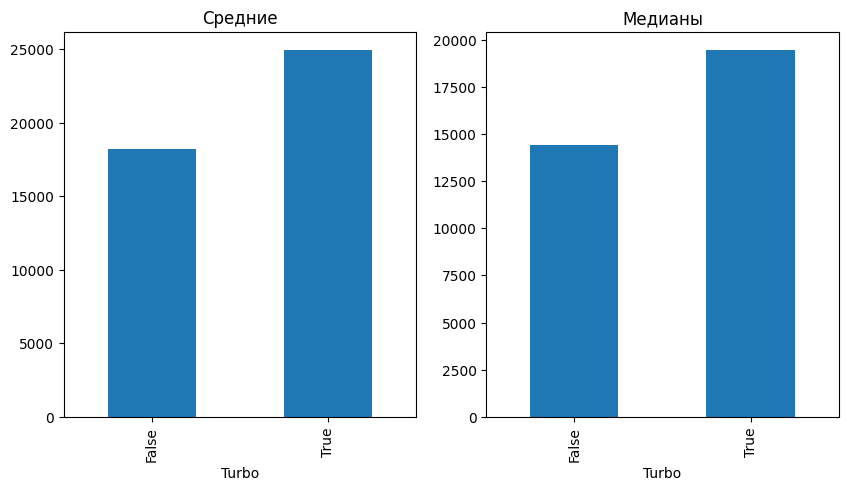

In [31]:
price_by_category(df, "Turbo", figsize=(10, 5))

- Mileage: численный, непрерывный, слабая корреляция с Price -0.21
- Mileage km/h: численный, непрерывный, слабая корреляция с Price -0.13

In [32]:
def mileage_to_int(x: str) -> int:
    return int(x.replace(" km", ""))
df["Mileage"] = df["Mileage"].apply(mileage_to_int)

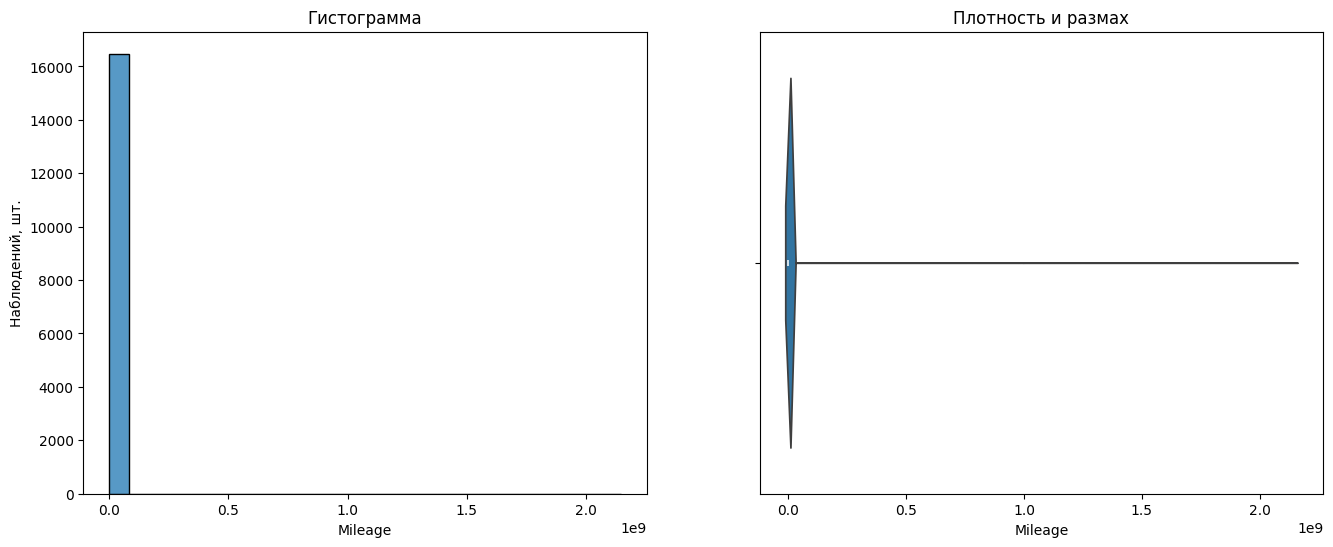

In [33]:
eda_visualize(df["Mileage"])

In [34]:
df["Mileage km/h"] = df["Mileage"]/((2023 - df["Prod. year"]) * 365 * 12)

In [35]:
df["Mileage km/h"].quantile(0.975)

9.578454555338116

In [36]:
df["Mileage km/h"].quantile(0.025)

0.0

In [37]:
df = df[df["Mileage km/h"] <= 10]

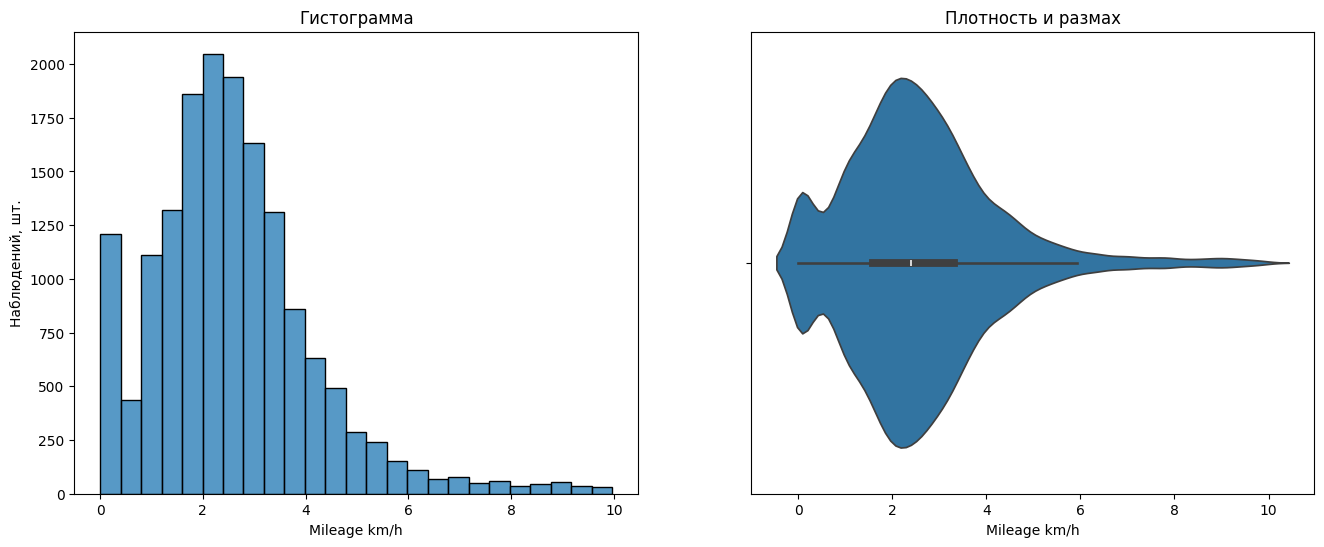

In [38]:
eda_visualize(df["Mileage km/h"])

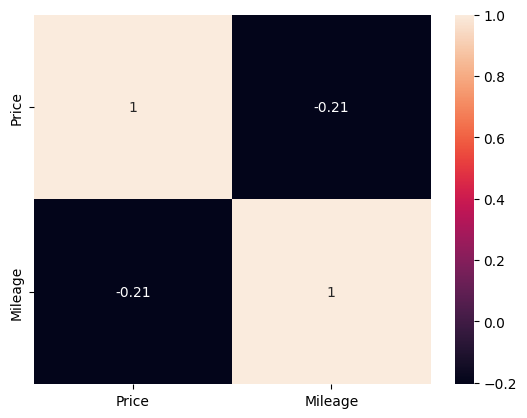

In [39]:
sns.heatmap(df[["Price", "Mileage"]].corr(), annot=True);

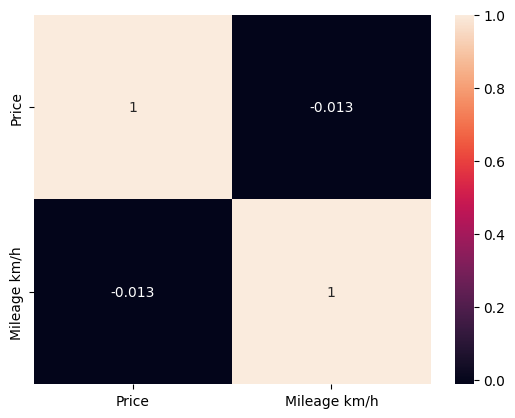

In [40]:
sns.heatmap(df[["Price", "Mileage km/h"]].corr(), annot=True);

- Cylinders: численный, дискретный, стоит попробовать сгруппировать

In [41]:
df = df.astype({"Cylinders": "int32"})

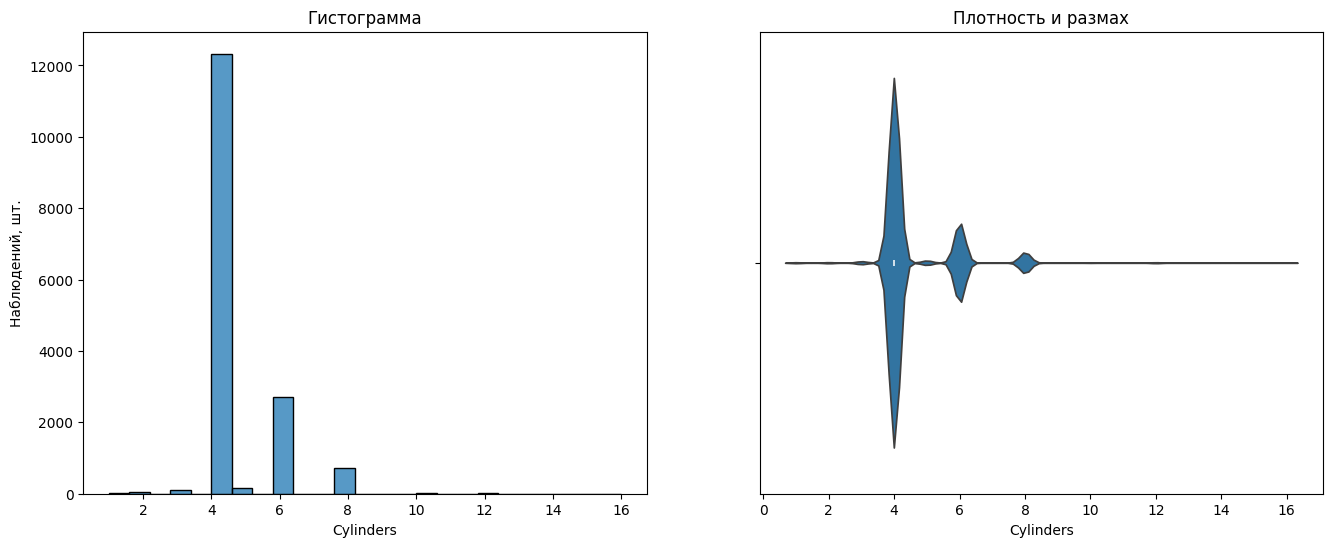

In [42]:
eda_visualize(df["Cylinders"])

- Wheel: логический, среднее при наличии возрастает, что говорит о связи

In [43]:
df["Right_hand"] = pd.get_dummies(df["Wheel"], drop_first=True)

,mean,median,count
Right_hand,,,
False,19974.076699,16308.0,14785
True,9775.723565,9000.0,1324


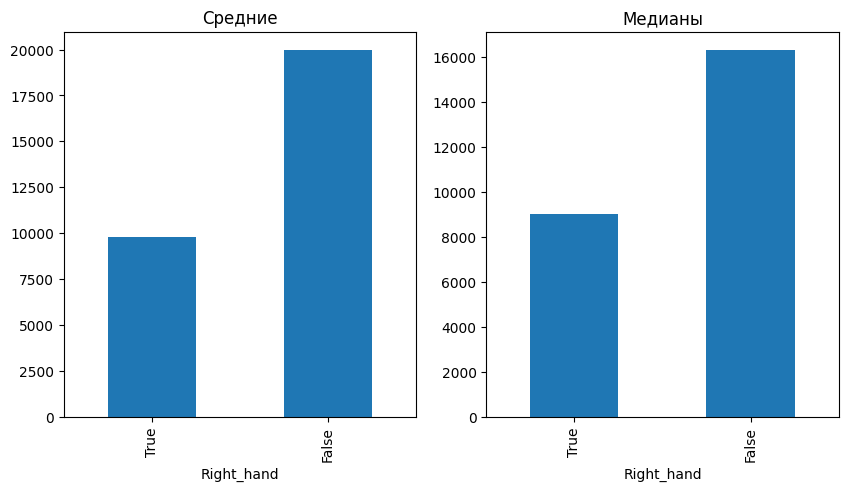

In [44]:
price_by_category(df, "Right_hand", figsize=(10, 5))

In [45]:
criterion_value, p_value = ttest_ind(df[df.Right_hand == 1]["Price"], df[df.Right_hand == 0]["Price"], equal_var=False)
criterion_value, p_value

(-57.75000209344494, 0.0)

- Gear box type:
    категориальный с малым кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Gear box type,,,
Automatic,19156.100830,15612.0,10721
Manual,11913.514977,9095.0,1736
Tiptronic,24195.759932,18817.0,2945
Variator,15486.350778,13799.0,707


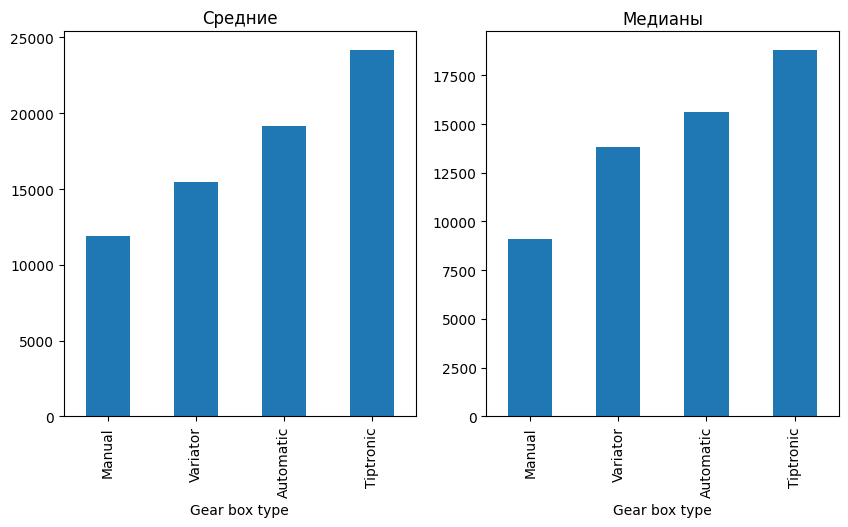

In [46]:
price_by_category(df, "Gear box type", figsize=(10, 5))

- Drive wheels:
    категориальный с малым кол-вом категорий
    среднее по категории возрастает, но слабо, вряд ли имеет значимую связь

,mean,median,count
Drive wheels,,,
4x4,21962.004572,15681.0,3062
Front,18560.993129,15681.0,11061
Rear,17980.351964,12858.0,1986


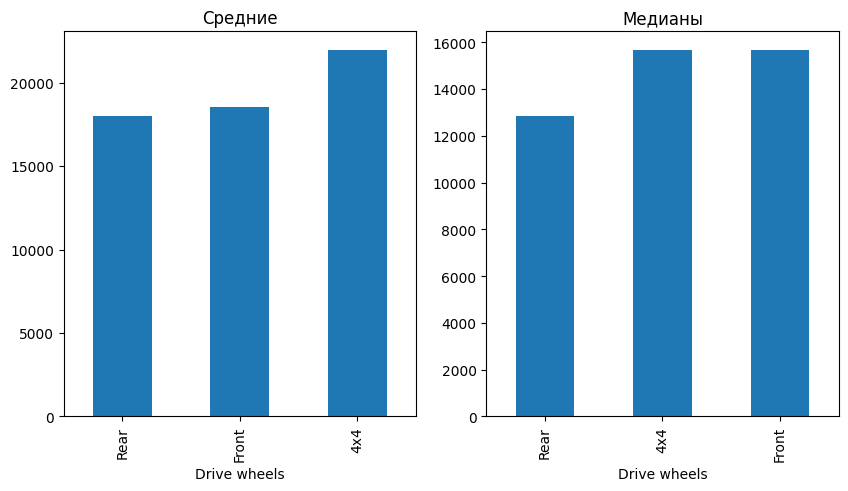

In [47]:
price_by_category(df, "Drive wheels", figsize=(10, 5))

- Doors:
    категориальный с малым кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Doors,,,
02-Mar,15275.919718,11054.5,710
04-May,19286.905790,15681.0,15285
>5,22925.649123,17249.0,114


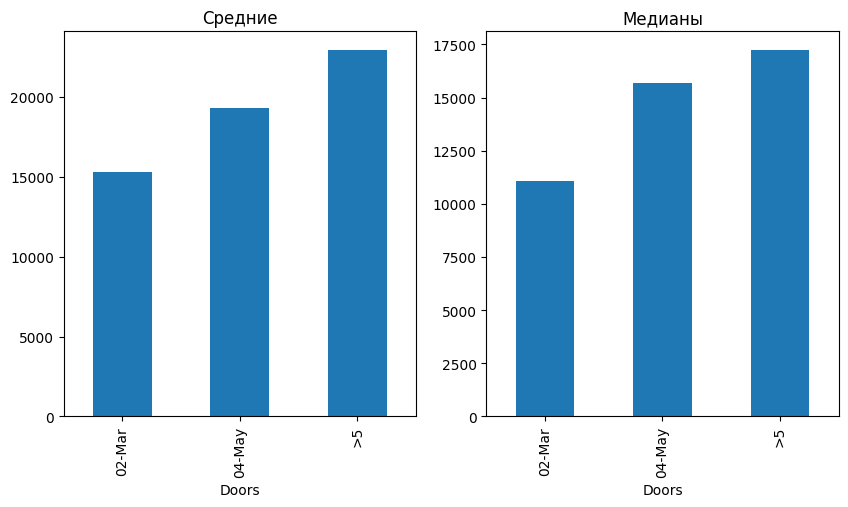

In [48]:
price_by_category(df, "Doors", figsize=(10, 5))

- Color:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи, стоит попробовать без.

,mean,median,count
Color,,,
Beige,16784.825000,13328.5,120
Black,20841.452647,16621.0,4118
Blue,16558.338829,11917.0,1213
Brown,22541.160256,17249.0,156
Carnelian red,16074.446429,15053.0,168
Golden,14987.042254,12858.0,142
Green,10097.663082,7527.0,279
Grey,21933.109713,18189.0,1987
Orange,18163.806452,16930.0,62


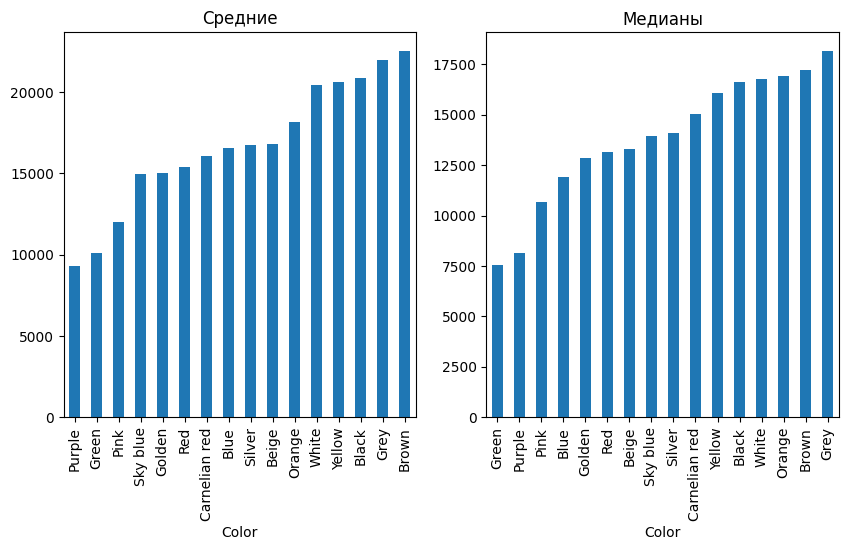

In [49]:
price_by_category(df, "Color", figsize=(10, 5))

- Airbags: численный, дискретный, стоит попробовать сгруппировать

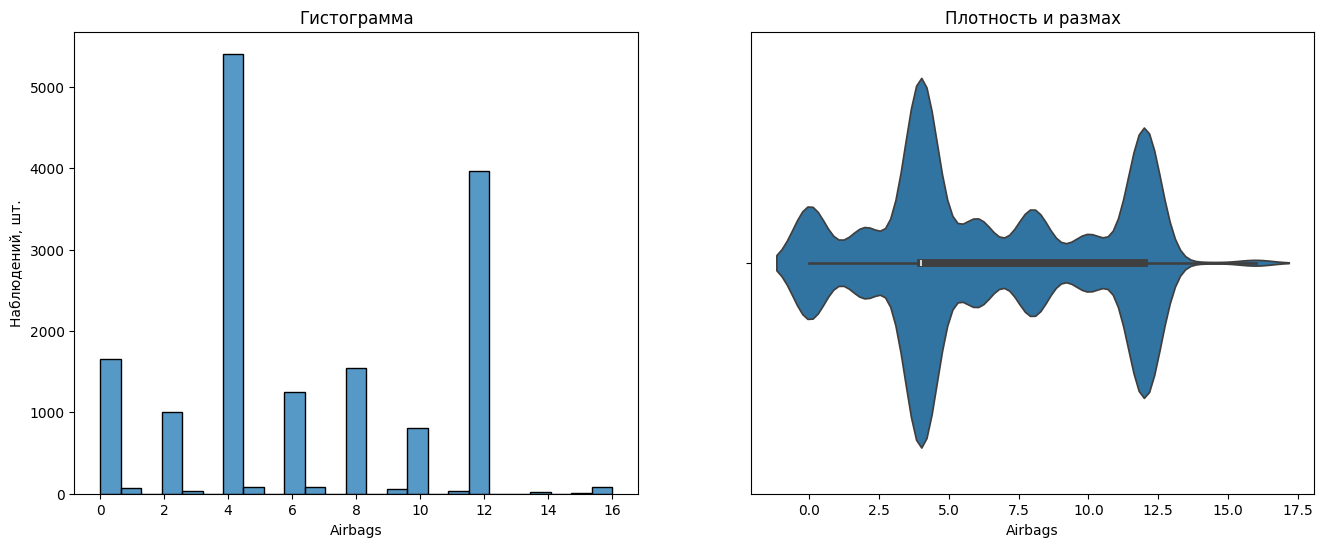

In [50]:
eda_visualize(df["Airbags"])

In [51]:
df = pd.concat([
    df,
    pd.get_dummies(df["Doors"], drop_first=True),
    pd.get_dummies(df["Drive wheels"], drop_first=True),
    pd.get_dummies(df["Gear box type"], drop_first=True),
], axis=1)
df = df.rename(columns={"04-May": "4 doors", ">5": ">5 doors"})

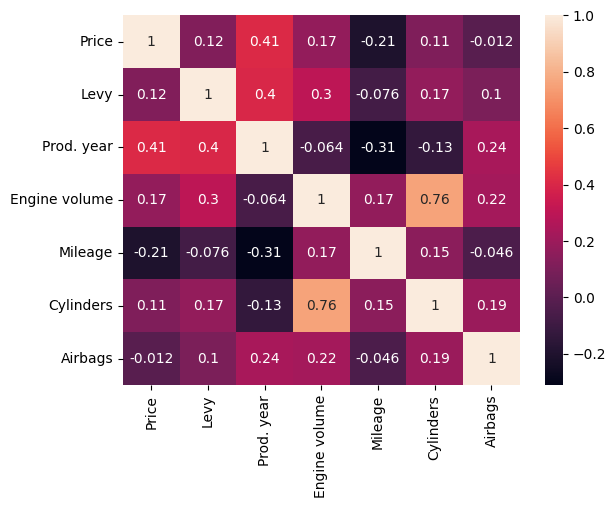

In [52]:
sns.heatmap(df[["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]].corr(), annot=True);

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16109 entries, 0 to 19235
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                16109 non-null  int64  
 1   Price             16109 non-null  int64  
 2   Levy              16109 non-null  int32  
 3   Manufacturer      16109 non-null  object 
 4   Model             16109 non-null  object 
 5   Prod. year        16109 non-null  int64  
 6   Category          16109 non-null  object 
 7   Leather interior  16109 non-null  bool   
 8   Fuel type         16109 non-null  object 
 9   Engine volume     16109 non-null  float64
 10  Mileage           16109 non-null  int64  
 11  Cylinders         16109 non-null  int32  
 12  Gear box type     16109 non-null  object 
 13  Drive wheels      16109 non-null  object 
 14  Doors             16109 non-null  object 
 15  Wheel             16109 non-null  object 
 16  Color             16109 non-null  object 
 17

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df["Price"],
    test_size=0.2,
    random_state=144,
    shuffle=True,
)

def predict_and_measure(model=None, params=None, drop_columns=None):
    if drop_columns is None:
        drop_columns = ["Price", "ID"]
    else:
        drop_columns = ["Price", "ID"] + drop_columns

    cols_for_encoding = [
        c for c in ["Model", "Manufacturer", "Color", "Fuel type", "Category"]
        if c not in drop_columns
    ]

    scaler_list = [
        None,
        MinMaxScaler(),
        StandardScaler(),
        RobustScaler(),
        PowerTransformer(),
        QuantileTransformer(random_state=0),
        QuantileTransformer(random_state=0, output_distribution='normal'),
    ]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('column_dropper', 'drop', drop_columns),
            ('encoder', LeaveOneOutEncoder(), cols_for_encoding),
        ],
        remainder='passthrough',
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(interaction_only=True, degree=2, include_bias=False)),
        ('scaler', StandardScaler()), # масштабирование
        ('model', model if model else LinearRegression()),
    ])

    if params is None:
        params = {
            # "scaler": scaler_list,
        }

    gs = GridSearchCV(
        pipeline,
        params,
        cv=4,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    gs.fit(X_train, y_train)
    prediction = gs.predict(X_test)

    return (
        gs.best_estimator_,
        mean_squared_error(y_test, prediction),
        mean_absolute_error(y_test, prediction),
        r2_score(y_test, prediction),
    )


In [55]:
m, mse, mae, r2 = predict_and_measure(drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel"])
mse, mae, r2

(82881153.03007221, 6205.623056482875, 0.6283401611548978)

46% r_score на всех столбцах, после более качественной работы над выбросами
Попробуем без модели

In [56]:
m, mse, mae, r2 = predict_and_measure(drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel", "Model"])
mse, mae, r2

(94219081.0780284, 6654.646917375325, 0.5774980534249073)

4.5% от признака модели

In [57]:
m, mse, mae, r2 = predict_and_measure(drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel", "4 doors", ">5 doors", "Front", "Rear"])
mse, mae, r2

(86153738.06318249, 6303.586118643775, 0.6136650705999758)

Тип дверей и привода на многое не влияют.
Попробуем убирать признаки без потери r_score.

In [58]:
m, mse, mae, r2 = predict_and_measure(
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)
mse, mae, r2

(89537280.93595205, 6485.319359847131, 0.598492417314581)

Следующим шагом попробую использовать TweedieRegressor.

In [59]:
m, mse, mae, r2 = predict_and_measure(
    model=TweedieRegressor(max_iter=1000),
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)
mse, mae, r2

(124113894.16892932, 7690.458679933633, 0.4434422275891189)

In [60]:
m, mse, mae, r2 = predict_and_measure(
    model=TweedieRegressor(power=1, max_iter=2000),
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)
mse, mae, r2

(84351929.86987668, 6211.942544544337, 0.6217448296075616)

In [61]:
m, mse, mae, r2 = predict_and_measure(
    model=TweedieRegressor(power=2, max_iter=100),
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)
mse, mae, r2

(123104505.95919883, 7496.717734141688, 0.44796857701411374)

r2_score при power = 1 54%

In [62]:
params = {
    "model__alpha": range(1, 10),
}

In [63]:
m, mse, mae, r2 = predict_and_measure(
    model=Lasso(),
    params=params,
    drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel"],
)
mse, mae, r2

/home/ptsvirko/Envs/car_pred/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+11, tolerance: 2.263e+08
  model = cd_fast.enet_coordinate_descent(
/home/ptsvirko/Envs/car_pred/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e+11, tolerance: 2.263e+08
  model = cd_fast.enet_coordinate_descent(
/home/ptsvirko/Envs/car_pred/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

(90703554.78004722, 6535.646701844754, 0.5932625534299848)

In [64]:
m, mse, mae, r2 = predict_and_measure(
    model=Ridge(),
    params=params,
    drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel"],
)
mse, mae, r2

(90162339.69769056, 6533.320448481293, 0.5956894973482991)

In [65]:
boost_params = {
    'preprocessor__pca__n_components':[1, 2, 3],
    'model__max_depth' : range(1, 10),
    'model__max_iter' : [200, 500, 1000],
}

In [66]:
m, mse, mae, r2 = predict_and_measure(
    model=HistGradientBoostingRegressor(random_state=79),
    drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel"],
)
mse, mae, r2

(179997327.48545167, 9522.040121267426, 0.1928469226107512)